In [8]:
# Pacotes

import matplotlib.pyplot as plt
import math
import astropy.io as io
from astropy.io import fits
import numpy as np
import glob
import pandas as pd
import re
from numpy import zeros

## 1) PROCESSO A SER REALIZADO

Esse pipeline tem como objetivo fazer a redução das imagens no que tange ao tratamento com bias frames (tratamento do erro de leitura) e flat frames (tratamento da inomogeneidade da sensibilidade pixel a pixel), aqui não faremos os tratamentos de dark frames (tratamento de fotoelétrons emitidos devido a aquecimento da CCD). Além disso, descrevemos a redução em um único filtro. O procedimento básico é descrito abaixo.

1) Temos um total de imagens flats e lights em um dado filtro, e um total de imagens bias (nesse caso não importa o filtro). Não consideramos imagens do tipo dark. <br>
2) Transformamos todas as imagens de bias em um cubo de dados e tiramos a mediana desse cubo de dados com todas as imagens, esse será nosso master bias (2D). <br>
3) Subtraímos o master bias tanto das imagens de ciência como flats. <br>
4) Dividimos cada imagem flat subtraída do bias pela sua média, assim temos as imagens flats normalizadas. <br>
5) Assim, como fizemos com os bias, transformamos as imagens flats reduzidas do bias e normalizadas em um cubo de dados, e disso tiramos a mediana tendo assim o master flat normalizado. Esse será nosso master flat normalizado. <br>
6) Dividimos as imagens de ciẽncia reduzidas do bias pelo master flat normalizado, tendo assim nossas imagens de ciência finais. <br>

Obs. O pipeline dá no final as imagens em ordem sequencial. No caso das imagens enviadas, tem uns pulos na numeração, então o número final não é o mesmo da imagem inicial.

## 2) COISAS PARA FAZER MANUALMENTE


A idéia desse pipeline é ser o mais automático possível. Então aqui vai ficar o que deve ser
feito pra rodá-lo. 

1) Mudar os caminhos: esse pipeline utiliza 5 pastas para guardar as imagens, e duas imagens (master bias e master flat normalizado) ficam na raíz, no mesmo lugar que esse código. Assim temos:

path_imagens_originais: caminho onde estão as imagens originais das imagens de ciência, flats e bias. <br>
path_ciencia_biasred: caminho onde estão as imagens de ciência subtraídas do master bias. <br>
path_flat_biasred: caminho onde estão as imagens flats reduzidas do master bias. <br>
path_flat_biasred_normalizados: caminho onde estão as imagens flats reduzidas do master bias e normalizadas. <br>
path_ciencia_corrigidas: caminho onde estão as imagens de ciência subtraídas do master bias e divididas pelo master flat normalizado. <br>

A célula abaixo apresenta os caminhos, basta alterar.

In [14]:
path_imagens_originais='/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/'
path_ciencia_biasred = '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/'
path_flat_biasred = '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/flats_biasred/'
path_flat_biasred_normalizados='/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/flats_biasred_normalizados/'
path_ciencia_corrigidas = '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_finais/'

2) Atrelar o tipo de imagem para os filtros de tipo de imagem: para rodar o pipeline, é necessário, classificar as imagens em ciencia, flats ou bias. Essa informação está no header da imagem, porém tanto o campo que informa isso quanto o texto que classifica varia. Assim é necessário delimitar esses filtros de imagens. Abaixo exemplifico o procedimento, inicialmente deve-se ver o header de uma imagem e avaliar qual o campo que traz essa informação. Neste caso foi o campo " OBJECT" e a minha imagem de bias está classificada como "zero".

In [19]:
# Lendo uma imagem

img,hdr=fits.getdata(path_imagens_originais + 'bias.B.0001.fits',header=True)

# Pegando informações do header

hdul=fits.open(path_imagens_originais + 'bias.B.0001.fits')

hdul.info()

hdul[0].header

Filename: /home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/bias.B.0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (1365, 1365)   float32   


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1365 / Axis length                                    
NAXIS2  =                 1365 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2012-12-09T23:37:41' / Date FITS file was generated                  
IRAF-TLM= '2012-12-09T23:38:45' / Time of last modification                     
OBJECT  = 'zero    '           / Name of the object observed                    
DETSIZE = '[1:4096,1:4096]'    / Detector size                                  
CCDSUM  = '3 3     '           / CCD pixel summing                              
CCDBIN1 =                   

In [20]:
hdul.close()

2.1) Feito isso, deve-se abrir uma imagem de cada tipo, já sabemos que neste caso as imagens de bias estão como "zero", vou fazer o mesmo para outras duas imagens e ver seus tipos. em vez de abrir o header todo, agora vou direto ao tipo "OBJECT".

In [21]:
# FLATS

hdul=fits.open('/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/flat.B.0001.fits')
print(hdul[0].header['Object'])

# Lights

hdul=fits.open('/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0002.fits')
print(hdul[0].header['Object'])


flat
XO-2b


In [41]:
hdul.close()

2.2) Como podemos ver, temos então que minhas imagens de bias estão como "zero", as de ciência como "X0-2b" e as flats como "flat". Na célula abaixo defino então qual o nome do campo do header que pede isso, assim como o nome da classificação de cada tipo de imagem. 

In [23]:
tipo='Object'
flat='flat'
bias='zero'
ciencia='XO-2b'

2.3) Pronto, com essas informações, as linhas de código abaixo gerarão as imagens de ciência. Importante destacar que este código não substitui imagens existentes, ou seja, caso determinada etapa gere um conjunto de imagens, e o processo se repita, dará erro. 

## 3) CRIANDO LISTAS DE IMAGENS

In [30]:
# Usando o glob pra ler todos os arquivos na pasta

files = [f for f in glob.glob(path_imagens_originais + "/*.fits", recursive=True)]

for f in files:
    print(f)
    
# Repare que nesse caso se quisesse avaliar pelo nome só, poderia usar o glob direto aqui 
#pra já fechar essas listas, mas isso só se o tipo de objeto estivesse no nome da imagem.
# Como a idéia aqui é fazer algo geral, não farei desse jeito.

/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0032.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0038.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0098.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0226.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0100.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0194.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/flat.B.0010.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/bias.B.0001.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/flat.B.0001.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0260.fits
/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_o

In [31]:
#Avaliando o tipo de objeto que é essa lista de imagens

type(files)

list

In [32]:
# Criando listas vazias pros 3 tipos

biasfiles=list()
flatfiles=list()
lightfiles=list()

In [33]:
# Sub-dividindo a lista files nos 3 tipos, lembrando de fechar pra poupar processamento.

for f in files:
    hdul=fits.open(f)
    if (hdul[0].header[tipo]==bias):   
        biasfiles.append(f)
        hdul.close()
    else:
        if (hdul[0].header[tipo]==flat):
            flatfiles.append(f)
            hdul.close()
        else:
            lightfiles.append(f)
            hdul.close()

In [34]:
# Pronto, já tenho minhas listas de imagens, agora uso os comandos abaixo pra fazer um cubo de
#dados, assim a primeira dimensão será o número da imagem do tipo em questão, as outras duas 
#são as dimensões de pixels. Assim temos 3 cubos de dados, um pra cada tipo de imagem

biascube = [ fits.getdata(image) for image in biasfiles ]
flatcube = [ fits.getdata(image) for image in flatfiles ]
lightcube = [ fits.getdata(image) for image in lightfiles ]


## 4) CRIANDO MASTER BIAS

In [35]:
# Vendo o total de imagens e de pixels em cada dimensão (não preciso mais, mas deixei aqui)

nbias=len(biascube)
nbiasprimd=len(biascube[0])
nbiassegd=len(biascube[0][0])

print(nbias,nbiasprimd,nbiassegd)

10 1365 1365


In [36]:
# Tirando a mediana das 10 imagens de bias, achatando meu cubo de dados 

master_bias=np.median(biascube,axis=0)


In [37]:
# Vou checar o tamanho, como pode ver tem 1365 por 1365, tá certo.

master_bias.shape

(1365, 1365)

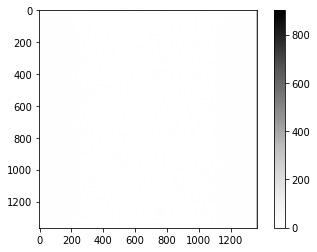

In [42]:
# Enfim, esse é meu master bias
# Estranho estar branco

plt.imshow(master_bias,cmap='Greys')
plt.colorbar()

In [43]:
# Teste (último pixel em ambas dimensões)

master_bias[nbiasprimd-1][nbiassegd-1]

313.63745

In [45]:
# Se eu fizer type(master_bias) vou ver que se trata de um numpy array, abaixo crio um arquivo fits com ele.

hdu = fits.PrimaryHDU(master_bias)
hdul = fits.HDUList([hdu])
hdul.writeto('master_bias.fits')
hdul.close()

## 5) REDUZINDO MASTER BIAS DAS DEMAIS IMAGENS

In [46]:
from numpy  import array

# PRIMEIRO REDUZO OS FLATS 

l = locals()
cont=1
for f in flatfiles:
    x=[fits.getdata(image) for image in flatfiles]
    img=array(x[cont-1])
    img2 = img-master_bias
    hdu = fits.PrimaryHDU(img2)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path_flat_biasred + 'flat_biasred' + str(cont) + '.fits')
    hdul.close()    
    cont=cont+1
    
l = locals()
cont=1
for f in lightfiles:
    x=[fits.getdata(image) for image in lightfiles]
    img=array(x[cont-1])
    img2 = img-master_bias
    hdu = fits.PrimaryHDU(img2)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path_ciencia_biasred + 'light_biasred' + str(cont) + '.fits')
    hdul.close()    
    cont=cont+1

    

In [47]:
# Aqui separo em grupos com o glob

flatfiles_biasred = [f for f in glob.glob(path_flat_biasred + "flat_biasred*.fits", recursive=True)]
lightfiles_biasred = [f for f in glob.glob(path_ciencia_biasred + "light_biasred*.fits", recursive=True)]

lightfiles_biasred

['/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred36.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred32.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred43.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred128.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred10.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred61.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred56.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred69.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred28.fits',
 '/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred20.fits',
 '/home/fabio/Faculdade/Tratamento de D

In [48]:
# Abaixo checo abrir uma imagem das reduzidas, vejo que tem contagens negativas, deve ser de regiões onde não há sinal
#astronômico e as contagens do bias superam são maiores, nesses casos não sei como faço. Deixo negativo ou zero.

img,hdr=fits.getdata('/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred2.fits',header=True)
print(img)
print(np.max(img))
img.shape

[[-1052.1492    -1063.4819    -1057.1459    ... -1228.3245
  -1216.0913    -1215.2501   ]
 [ -513.0233     -521.7311     -517.7179    ...  -604.4083
   -592.5071     -591.5614   ]
 [ -251.2395     -258.2262     -259.91266   ...  -303.52072
   -284.86197    -283.7772   ]
 ...
 [   18.966187      4.2117615     5.589905  ...     4.4740295
     19.948944     20.167694 ]
 [   17.705353      7.581085      3.6965637 ...     2.3892212
     16.767761     16.998016 ]
 [   15.746857      4.7013855     4.075348  ...     8.294891
     20.680847     20.84143  ]]
59513.574


(1365, 1365)

## 6) NORMALIZANDO IMAGENS FLAT REDUZIDOS DO BIAS

In [49]:
l = locals()
cont=1
for f in flatfiles_biasred:
    x=[fits.getdata(image) for image in flatfiles_biasred]
    img=array(x[cont-1])
    media=np.mean(img)
    img2 = img/media
    hdu = fits.PrimaryHDU(img2)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path_flat_biasred_normalizados + 'flat_biasred_normalizados' + str(cont) + '.fits')
    hdul.close()    
    cont=cont+1
    

## 7) CRIANDO MASTER FLAT A PARTIR DOS FLATS NORMALIZADOS

In [51]:
#Aqui, o procedimento é exatamente igual a criação do master bias

# Primeiro vou criar um cubo de dados pros flats reduzidos do bias e normalizados:

flatfiles_biasred_normalizados = [f for f in glob.glob(path_flat_biasred_normalizados + "flat_biasred_normalizado*.fits", recursive=True)]

flatredbiasnormalizadocube = [ fits.getdata(image) for image in flatfiles_biasred_normalizados ]

# O número de imagens, e pixels de imagens de flat é o mesmo que s de bias, são 10 imagens,
#cada uma com 1365, mas como aqui o pipeline é geral e poderia não ser assim, vou primeiro
#guardar esses valores numa variável diferente

nbias=len(flatredbiasnormalizadocube)
nbiasprimd=len(flatredbiasnormalizadocube[0])
nbiassegd=len(flatredbiasnormalizadocube[0][0])

print(nbias,nbiasprimd,nbiassegd)

10 1365 1365


In [52]:
# Agora vou de fato fazer o masterflat, da fórmula anterior, eu só mudei mesmo os nomes, porque
#são 10 imagens, mas lembre-se que essa parte devo mudar manualmente.

master_flat_normalizado = np.median(flatredbiasnormalizadocube,axis=0)

In [53]:
# Por fim crio o arquivo do master flat

hdu = fits.PrimaryHDU(master_flat_normalizado)
hdul = fits.HDUList([hdu])
hdul.writeto('master_flat_normalizado.fits')
hdul.close()

## 8) REDUZINDO O MASTER FLAT NORMALIZADO DAS IMAGENS DE CIÊNCIA

In [55]:
# REDUZINDO IMAGENS DE CIÊNCIA E SALVANDO NA PASTA, A DIFERENÇA É QUE DIFERENTEMENTE DO BIAS
#AQUI EU DIVIDO E NÃO SUBTRAIO. 

l = locals()
cont=1
for f in lightfiles_biasred:
    x=[fits.getdata(image) for image in lightfiles_biasred]
    img=array(x[cont-1])
    img2 = img/master_flat_normalizado
    hdu = fits.PrimaryHDU(img2)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path_ciencia_corrigidas + 'ciencia_final' + str(cont) + '.fits')
    hdul.close()    
    cont=cont+1
    

In [56]:
# Aqui abaixo só uns testes que deixei pra ver o formato dos arquivos.

In [57]:
img2.shape

(1365, 1365)

In [58]:
img,hdr=fits.getdata('/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_biasred/light_biasred1.fits',header=True)
img.shape

(1365, 1365)

In [59]:
img,hdr=fits.getdata('/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/imagens_originais/xo2b/xo2b.0002.fits',header=True)
img.shape

(1365, 1365)

In [60]:
master_flat_normalizado.shape

(1365, 1365)

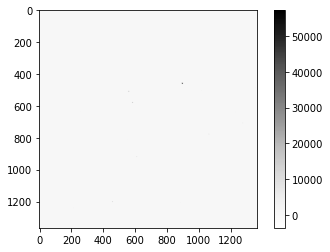

In [61]:
# Vou abrir alguma imagem de ciência final pra ver

img,hdr=fits.getdata('/home/fabio/Faculdade/Tratamento de Dados/Projeto/rep1/ciencia_finais/ciencia_final1.fits',header=True)

plt.imshow(img,cmap='Greys')
plt.colorbar()